# X-Ray Image Classification

## Import Modules and Packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import re
import os 
import urllib.request
import random
import pickle
import boto3
from PIL import Image
from glob import glob
from copy import deepcopy

#Sci-Kit Learn Modules
from skimage import color
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score, accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix 
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

#Tensorflow Modules
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.compat.v1 import set_random_seed

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import models, metrics 
from tensorflow.keras.applications import imagenet_utils, ResNet50V2, ResNet101V2, ResNet152V2, VGG19 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.layers import Activation, BatchNormalization, UpSampling2D, Dropout, Flatten, Dense 
from tensorflow.keras.layers import Input, ReLU, LeakyReLU, Conv2DTranspose, AveragePooling2D, Concatenate

from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.initializers import he_normal, he_uniform, glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
from tensorflow.keras.metrics import Recall, Precision, Accuracy, AUC


In [4]:
import time
from tqdm import tqdm_notebook as tqdm

## Read in Image Data

In [45]:
# Directory path
train_data_dir = 'xrays/train/'
test_data_dir = 'xrays/test'
val_data_dir = 'xrays/val'

# Get train images from directory xrays/train, augment, and reshape them
train_generator = ImageDataGenerator(rescale = 1.0/255.,
                                     rotation_range = 3,
                                     width_shift_range=0.05,
                                     height_shift_range = 0.05,
                                     shear_range = 0.05,
                                     zoom_range = 0.05,
                                     ).flow_from_directory(train_data_dir, 
                                                           target_size=(256, 256),
                                                           class_mode='binary',
                                                           color_mode='grayscale',
                                                           seed=42)

# Get test images from directory xrays/test, and reshape them
test_generator = ImageDataGenerator(rescale = 1.0/255.,
                                   ).flow_from_directory(test_data_dir, 
                                                         target_size=(256, 256),
                                                         class_mode='binary',
                                                         color_mode='grayscale',
                                                         shuffle = False)


# Get validation images from directory xrays/val, and reshape them
val_generator = ImageDataGenerator(rescale = 1.0/255.,
                                   ).flow_from_directory(val_data_dir, 
                                                         target_size=(256, 256),
                                                         class_mode='binary',
                                                         color_mode='grayscale',
                                                         shuffle=False)

Found 4616 images belonging to 2 classes.
Found 640 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


## Exploratory Data Analsis

### Visualizing Images in Dataset

**Previewing a few images from dataset**

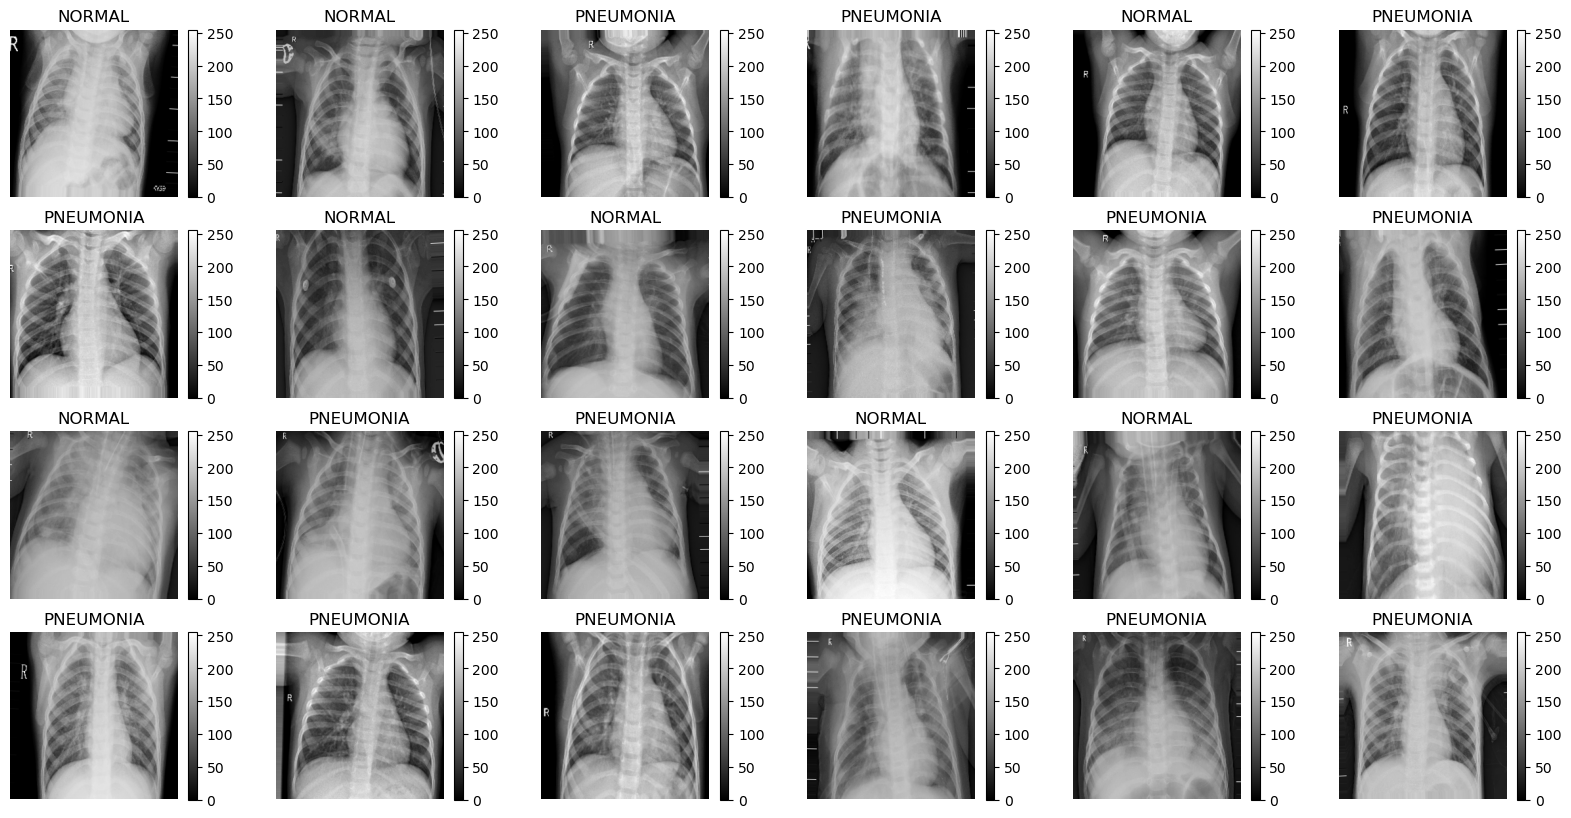

In [6]:
# Images and Labes from Training Set
X_train = next(train_generator)[0]

plt.style.use('default')
fig=plt.figure(figsize=(20, 10))
columns = 6; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]        
        dic = {0:"NORMAL", 1:"PNEUMONIA"}
        plt.title(dic.get(Y_batch[0]))
        plt.axis("off")
        plt.imshow(array_to_img(X_train[i]), cmap=plt.cm.gray)
        plt.colorbar()
        fig.add_subplot
        break

The x-ray images of patients with pneumonia appear cloudier around the lung area. 

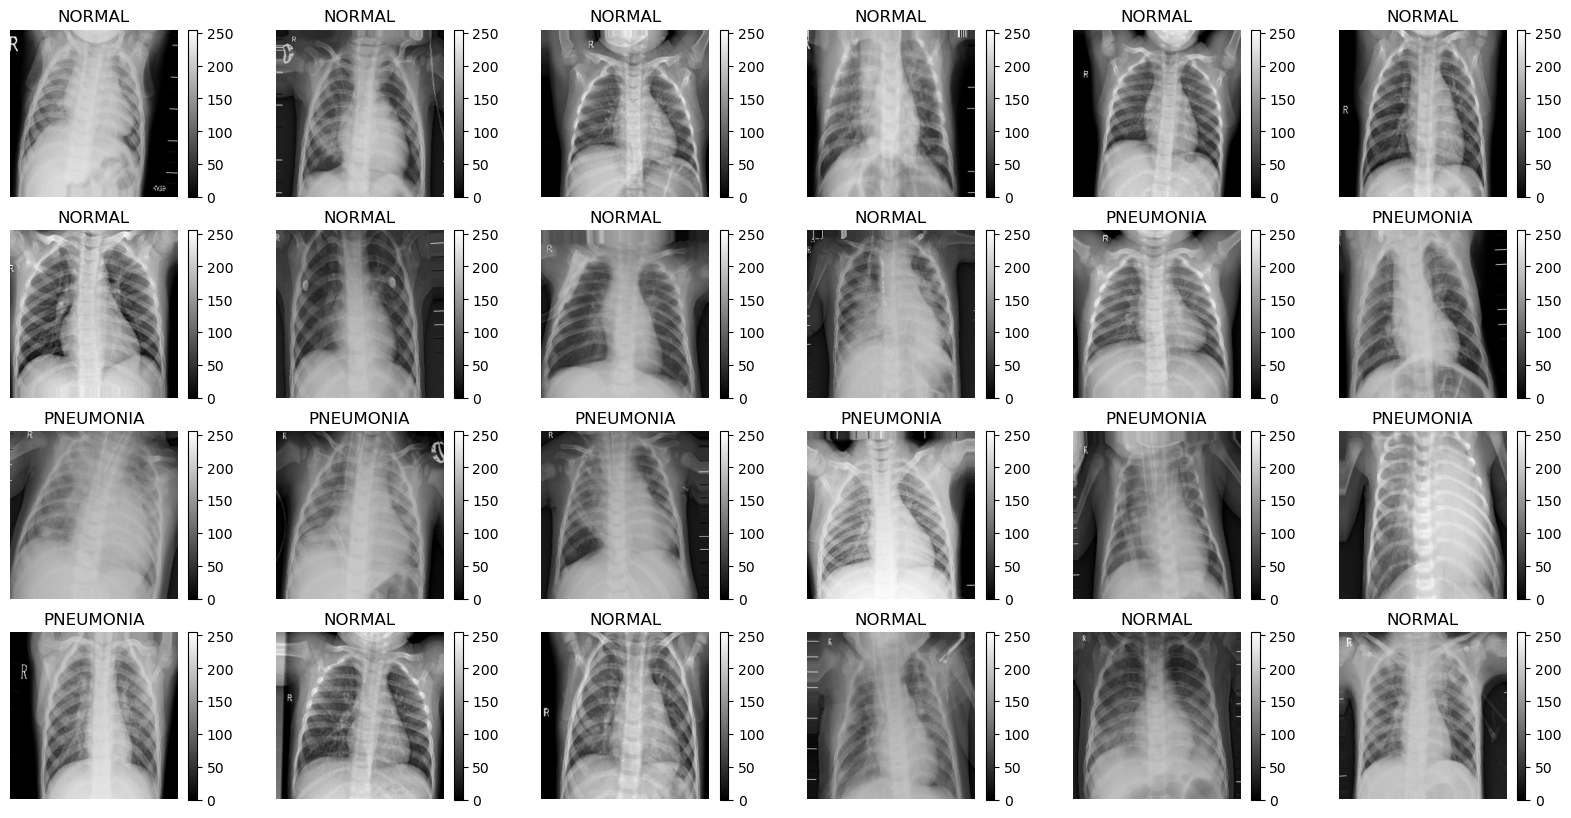

In [7]:
#Images and Labels from Validation Set

plt.style.use('default')
fig=plt.figure(figsize=(20, 10))
columns = 6; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    for X_batch, Y_batch in val_generator:
        image = X_batch[0]        
        dic = {0:"NORMAL", 1:"PNEUMONIA"}
        plt.title(dic.get(Y_batch[0]))
        plt.axis("off")
        plt.imshow(array_to_img(X_train[i]), cmap=plt.cm.gray)
        plt.colorbar()
        fig.add_subplot
        break

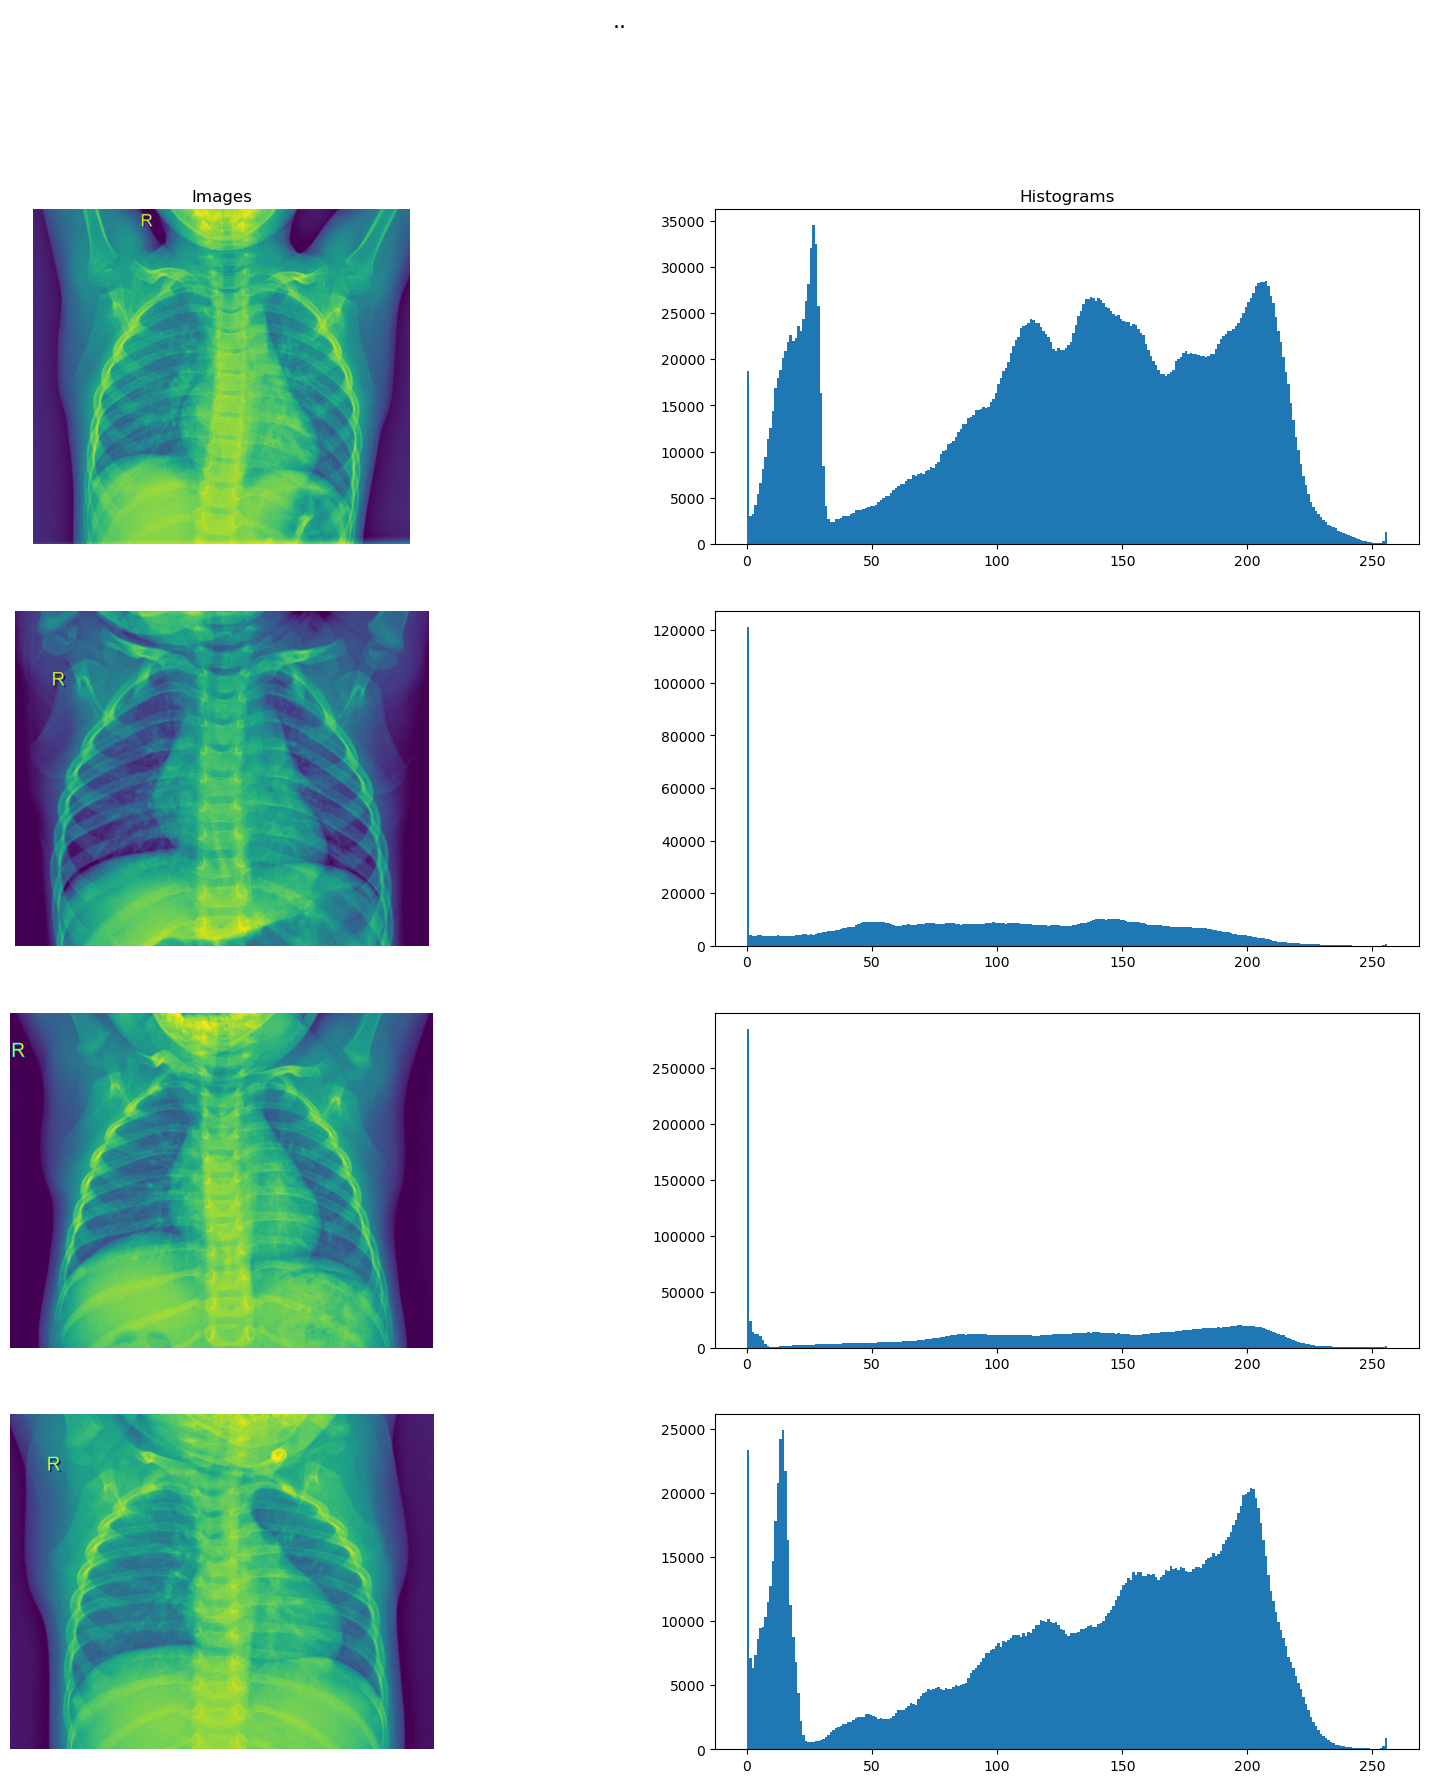

In [8]:
# display 4 image histograms 
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

for row, file_path in enumerate(train_generator.filepaths[:4]):
    image = plt.imread(file_path)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('..', size=16)
plt.show()

### Visualizing Class Counts

In [9]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

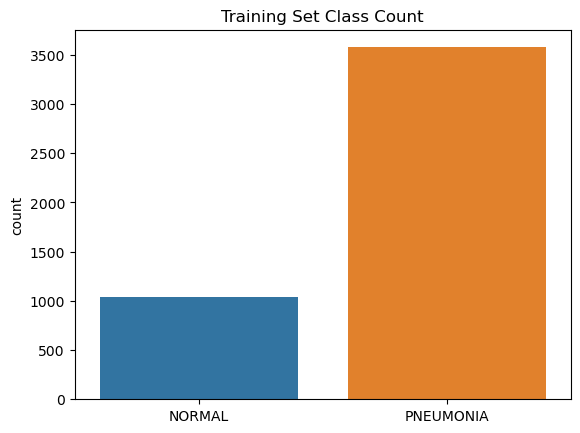

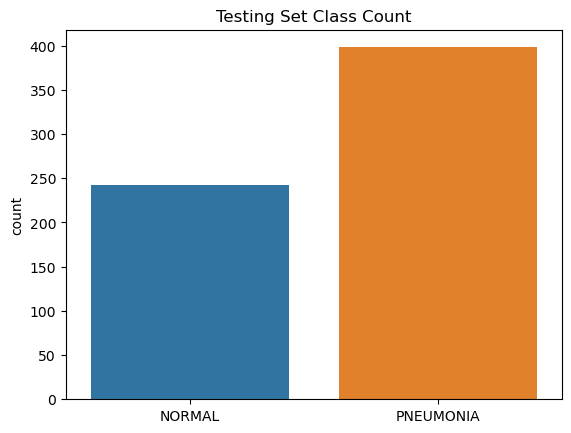

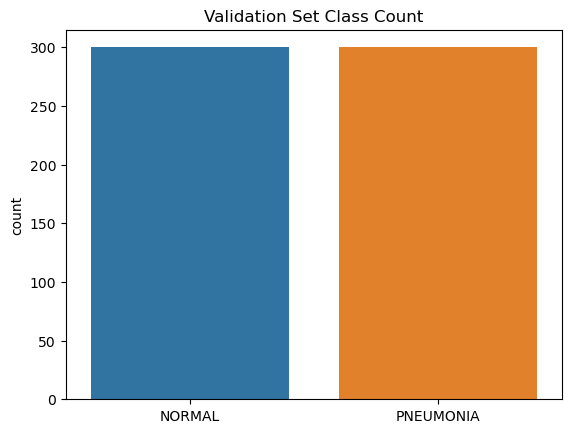

In [10]:
# Plot Class Frequency in Training, Testing, and Validation sets
train_class = train_generator.classes
test_class = test_generator.classes
val_class = val_generator.classes


a = np.where(train_class == 0, 'NORMAL', 'PNEUMONIA')
b = np.where(test_class == 0, 'NORMAL', 'PNEUMONIA')
c = np.where(val_class == 0, 'NORMAL', 'PNEUMONIA')

sns.countplot(x = a)
plt.title("Training Set Class Count")
plt.show()

sns.countplot(x = b)
plt.title("Testing Set Class Count")
plt.show()

sns.countplot(x = c)
plt.title("Validation Set Class Count")
plt.show()

The class imbalance in the training set is quite clear. In order to create a more balanced training set, we adjusted the class weights in our models.

## Dealing with Class Imbalance in Training Set

In [11]:
from sklearn.utils import class_weight

class_weights = dict(zip(np.unique(train_class), class_weight.compute_class_weight(class_weight = 'balanced',
                                                                               classes = np.unique(train_class),
                                                                               y = train_class))) 

In [12]:
class_weights

{0: 2.217098943323727, 1: 0.6455944055944056}

These are the adjusted weights for our "0" or Normal class, and our "1" or Pneumonia class. As you can see, the weights applied to our Normal class is greater to account for the class imbalance.

## Modeling Process

## Model Q

In [15]:
# instantiate model
modelq = models.Sequential()
# add convultional layer and pooling layer
modelq.add(Conv2D(32, (3, 3), kernel_initializer=he_uniform(), activation='relu', input_shape=(256, 256, 1)))
modelq.add(MaxPooling2D((2, 2)))
# add similar layer pair with 64 nodes
modelq.add(Conv2D(64, (3, 3), kernel_initializer=he_uniform(), activation='relu'))
modelq.add(MaxPooling2D((2, 2)))
# add similar layer pair with 128 nodes
modelq.add(Conv2D(128, (3, 3), kernel_initializer=he_uniform(), activation='relu'))
modelq.add(MaxPooling2D((2, 2)))
# add another to further reduce feature tensor dimensions
modelq.add(Conv2D(128, (3, 3), kernel_initializer=he_uniform(), activation='relu'))
modelq.add(MaxPooling2D((2, 2)))
# flatten and send to output layer
modelq.add(Flatten())
modelq.add(Dropout(0.5))
modelq.add(Dense(512, kernel_initializer=he_uniform(), activation='relu'))
modelq.add(Dense(1, activation='sigmoid'))
# show model blueprint
modelq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [16]:
from keras_tqdm import TQDMNotebookCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', 
                            save_best_only=True),TQDMNotebookCallback()]

In [17]:
#Compile model
compileparams = modelq.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), 
                               metrics=[Recall(), Precision(),'acc'])
#Fit the model to Training Set and Validate on Validation set
history_q = modelq.fit(train_generator, 
                    validation_data=val_generator,
                    steps_per_epoch= 144,
                    epochs=50,
                    class_weight = class_weights)

In [18]:
# save model to JSON
modelq_json = modelq.to_json()
with open("models/model_q/modelq.json", "w") as json_file:
    json_file.write(modelq_json)

# save weights to HDF5
modelq.save_weights("models/model_q/model_q_weights.h5")
print("Saved model to disk")

modelq.save('models/model_q/model_q.h5')  # creates a HDF5 file 'my_model.h5'
# del modelq  # deletes the existing model

Saved model to disk


### Plotting Validation Accuracy and Loss for Model Q

In [94]:
# define visualization function
def plot_model(history, epochs):
    # allow either imported history or direct history to run 
    if type(history_q) != pd.core.frame.DataFrame:
        history = history.history
    
    # set graph style
    plt.style.use('seaborn-dark')
    fig = plt.figure(figsize=(16,6))
    
    #visualize loss
    ax1 = fig.add_subplot(121)
    plt.plot(range(1, epochs+1), history['loss'], label='train loss')
    plt.plot(range(1, epochs+1), history['val_loss'], label= 'val loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('number of epochs')
    plt.legend()

    
    # visualize accuracy
    ax2 = fig.add_subplot(122)
    plt.plot(range(1, epochs+1), history['acc'], label = 'train acc')
    plt.plot(range(1, epochs+1), history['val_acc'], label = 'val acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('number of epochs')
    plt.legend()

In [110]:
# import history if model wasn't fit
try:
    history_q
except NameError:
    history_q = pd.read_csv('models/model_q/modelq_history.csv', index_col='Unnamed: 0')

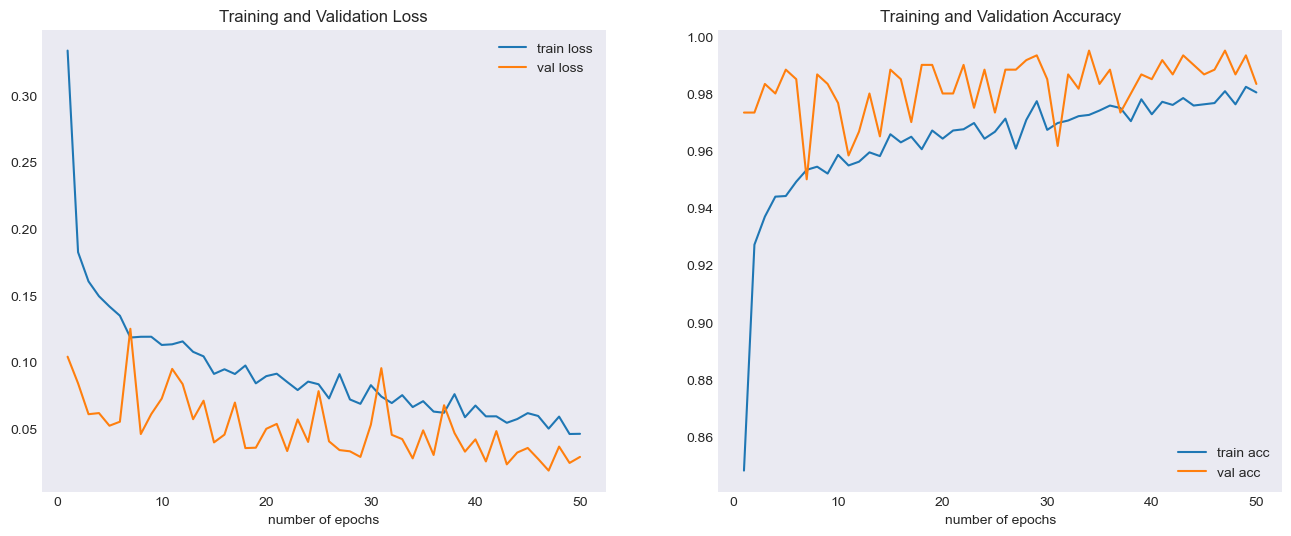

In [95]:
# plot model q
plot_model(history_q, 50)

### Confusion Matrix for Model Q

**Predict on test set**

In [135]:
# load saved model if model wasn't run
if type(history_q) == pd.core.frame.DataFrame:
    modelq = tf.keras.models.load_model('models/model_q/model_q.h5')
# define function for confusion matrix plot
def model_conf(model, history):

    # make predictions on test set       
    y_pred_ = model.predict(test_generator) > 0.5
    # create list holding ground truth
    y_true = test_generator.classes
    
    # create raw confusion matrix 
    cm_q = confusion_matrix(y_true, y_pred_q)
    # create visualization for confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_q, display_labels=["Normal", "Pneumonia"])
    disp.plot(cmap='Blues')
    plt.show()

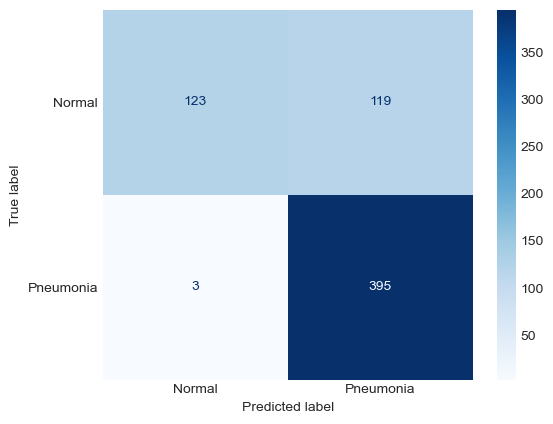

In [133]:
model_conf(modelq, history_q)

## Viewing Missed Casses

In [33]:
miss_class = y_pred_q.squeeze() != y_true.squeeze()

In [34]:
missed_idx = [idx for idx, y in enumerate(miss_class) if y]

In [35]:
Xs = []
ys = []
i = 0
while i < 20:
    batch = next(test_generator)
    Xs.extend(batch[0])
    ys.extend(batch[1])
    i += 1

In [36]:
missed_xray = [(X, y) for idx, (X, y) in enumerate(zip(Xs, ys)) if idx in missed_idx]

Example 1

actual 0.0
predicted [ True]
False Positive


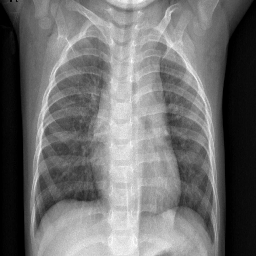

In [37]:
# show false positve
print('actual', missed_xray[5][1])
print('predicted', y_pred_q[missed_idx[5]])
print('False Positive')
array_to_img(missed_xray[5][0])

Example 2

In [41]:
# locate false negatives
FN = [i for i, idx in enumerate(missed_idx) if y_pred_q[idx] == False]

actual 1.0
predicted [False]
False Negative


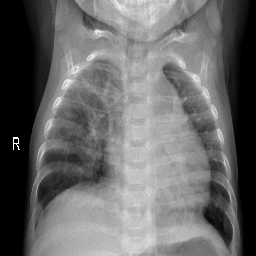

In [42]:
# show false negative
print('actual', missed_xray[FN[0]][1])
print('predicted', y_pred_q[missed_idx[FN[0]]])
print('False Negative')
array_to_img(missed_xray[FN[0]][0])

### Evaluating Model Q's Performance on Test Set

In [122]:
score_q = modelq.evaluate(test_generator, verbose=0)
print(f'Model Q Loss:      {round(score_q[0],2)} \nModel Q Accuracy:  {round(score_q[3],2)}')
print(f'Model Q Recall:    {round(score_q[1],2)} \nModel Q Precision: {round(score_q[2],2)}')

Model Q Loss:      0.92 
Model Q Accuracy:  0.81
Model Q Recall:    0.99 
Model Q Precision: 0.77


ROC Curve

In [148]:
def plot_roc_curve(model):
    y_val_prob = model.predict(test_generator)

    fpr, tpr, thresholds = roc_curve(test_generator.classes , y_val_prob)

 
    plt.plot(fpr,tpr)  
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.plot([0,1], [0,1])
    plt.show()    

    return roc_auc_score(test_generator.classes, y_val_prob) 

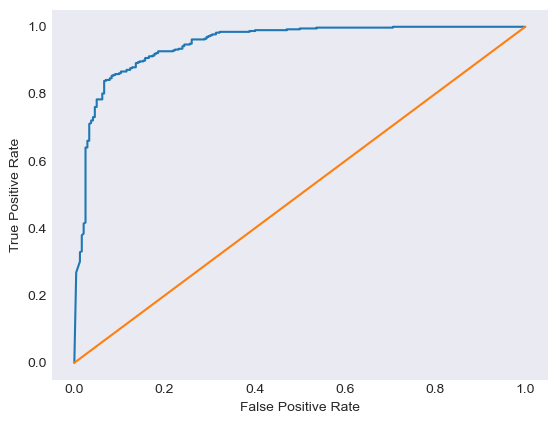

0.9480408239544831

In [147]:
plot_roc_curve(modelq) 

## Model R - Minor Changes

In [ ]:
# previous model structure
modelr = models.Sequential()

modelr.add(Conv2D(32, (7, 7), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu', input_shape=(256, 256, 1)))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(64, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(128, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(128, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(256, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(256, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Flatten())
modelr.add(Dropout(0.5))
modelr.add(Dense(512, kernel_initializer=he_uniform(), activation='relu'))
modelr.add(Dense(1, activation='sigmoid'))

modelr.summary()

In [ ]:
#Compile model
modelr.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=[Recall(), Precision(),'acc'])

In [ ]:
#Fit the model to Training Set and Validate on Validation set
history_r = modelr.fit(train_generator, 
                    validation_data = val_generator,
                    steps_per_epoch = 144,
                    epochs=50,
                    class_weight = class_weights)

In [ ]:
save_model=tf.keras.models.load_model('CIFAR1006.h5')

### Plotting Validation Accuracy and Loss for Model R

In [ ]:
# import history if model wasn't fit
try:
    history_r
except NameError:
    history_r = pd.read_csv('models/model_r/modelr_history.csv', index_col='Unnamed: 0')

In [ ]:
plot_model(history_r, 50)

### Confusion Matrix for Model R

**Predict on test set**

In [ ]:
if type(history_r) == pd.core.frame.DataFrame:
    modelr = tf.keras.models.load_model('models/model_r/model_r.h5')

model_conf(modelr, history_r)

### Evaluating Model R's Performance on Test Set

In [36]:
score_r = modelr.evaluate(test_generator, verbose=0)
print(f'Model R Loss:      {round(score_r[0],2)} \nModel R Accuracy:  {round(score_r[3],2)}')
print(f'Model R Recall:    {round(score_r[1],2)} \nModel R Precision: {round(score_r[2],2)}')

In [ ]:
plot_roc_curve(modelr)

## Model T

In [37]:
# overfit model
modelt = models.Sequential()


modelt.add(Conv2D(16, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same',input_shape=(256, 256, 1)))
modelt.add(Conv2D(16, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(MaxPool2D((2, 2)))


modelt.add(SeparableConv2D(32, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(SeparableConv2D(32, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2, 2)))


modelt.add(SeparableConv2D(64, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(SeparableConv2D(64, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2, 2)))


modelt.add(SeparableConv2D(128, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(SeparableConv2D(128, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2, 2)))
modelt.add(Dropout(rate=0.2))


modelt.add(SeparableConv2D(256, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(SeparableConv2D(256, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2, 2)))
modelt.add(Dropout(0.2))


modelt.add(Flatten())
modelt.add(Dense(512, kernel_initializer=he_uniform(), activation='relu'))
modelt.add(Dropout(0.5))
modelt.add(Dense(128, kernel_initializer=he_uniform(), activation='relu'))
modelt.add(Dropout(0.5))
modelt.add(Dense(64, kernel_initializer=he_uniform(), activation='relu'))
modelt.add(Dropout(0.3))

modelt.add(Dense(1, activation='sigmoid'))
   
    
modelt.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 128, 128, 32)      688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 128, 128, 32)      1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)       

In [ ]:
#Compile model 
modelt.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=[Recall(), Precision(),'acc'])

#Fit the model to Training Set and Validate on Validation set
history_t = modelt.fit(train_generator, 
                    validation_data=(val_generator),
                    steps_per_epoch= 144,
                    epochs=50,
                    class_weight = class_weights
                    )

In [ ]:
# import history if model wasn't fit
try:
    history_t
except NameError:
    history_t = pd.read_csv('models/model_t/modelt_history.csv', index_col='Unnamed: 0')

In [ ]:
plot_model(history_t, 50)

### Confusion Matrix for Model T

In [ ]:
if type(history_t) == pd.core.frame.DataFrame:
    modelt = tf.keras.models.load_model('models/model_t/model_t.h5')

model_conf(modelt, history_t)

### Evaluating Model T's Performance on Test Set

In [ ]:
score_t = modelt.evaluate(test_generator, verbose=1)
print(f'Model T Loss:      {round(score_t[0],2)} \nModel T Accuracy:  {round(score_t[3],2)}')
print(f'Model T Recall:    {round(score_t[1],2)} \nModel T Precision: {round(score_t[2],2)}')

### Model T's ROC-AUC Curve

In [ ]:
plot_roc_curve(modelt)

## Model Z

In [38]:
# model with regularization
modelz = models.Sequential()

modelz.add(Conv2D(32, (7,7), kernel_initializer=he_uniform(), kernel_regularizer=l2(), activation='relu', input_shape=(256, 256, 1)))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(32, (3,3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), activation='relu'))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(128,(3,3), kernel_initializer=he_uniform(), activation='relu'))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(64,(3,3), kernel_initializer=he_uniform(), activation='relu'))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(128,(3,3), kernel_initializer=he_uniform(), activation='relu'))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(128,(3,3), kernel_initializer=he_uniform(), activation='relu'))
modelz.add(MaxPooling2D(2,2))
    

modelz.add(Flatten())
modelz.add(Dense(128, kernel_initializer=he_uniform(), activation='relu'))
modelz.add(Dropout(0.5))

modelz.add(Dense(1, activation='sigmoid'))

modelz.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 250, 250, 32)      1600      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 123, 123, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 59, 59, 128)       36992     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 64)       

In [ ]:
#Compile model 
modelz.compile(Adam(lr=1e-6),loss = 'binary_crossentropy', metrics=[Recall(), Precision(),'acc'])

In [ ]:
#Fit the model to Training Set and Validate on Validation set
history_z = modelz.fit(train_generator,
                    validation_data =(val_generator),
                    epochs = 17,
                    steps_per_epoch=144
                    class_weight=class_weights,
                    verbose=2)

### Plotting Validation Accuracy and Loss for Model Z

In [ ]:
# import history if model wasn't fit
try:
    history_z
except NameError:
    history_z = pd.read_csv('models/model_z/modelz_history.csv', index_col='Unnamed: 0')

In [ ]:
plot_model(history_z, 50)

### Confustion Matrix for Model Z

In [ ]:
if type(history_z) == pd.core.frame.DataFrame:
    modelz = tf.keras.models.load_model('models/model_z/model_z.h5')

model_conf(modelz, history_z)

### Evaluating Model Z's Performance on Test Set

In [ ]:
score_z = modelz.evaluate(test_generator, verbose=0)
print(f'Model Z Loss:      {round(score_z[0],2)} \nModel Z Accuracy:  {round(score_z[3],2)}')
print(f'Model Z Recall:    {round(score_z[1],2)} \nModel Z Precision: {round(score_z[2],2)}')

### Model Z's ROC-AUC Curve

In [ ]:
plot_roc_curve(modelz)